<a href="https://colab.research.google.com/github/mojtabaSefidi/DataScience-SmallProjects/blob/master/Sentiment_Analysis_Using_DeepLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q wordcloud
!pip install -q tqdm
!pip install -q emoji
!pip install -q swifter
!pip install -q sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 358.9/358.9 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 8.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 633.9 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 41.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 33.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 28.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 45.0 MB/s eta 0:00:00


In [2]:
import os
import pandas as pd
import numpy as np
import string
import nltk
import gensim
import re
from keras.utils import pad_sequences
from keras.preprocessing.text import Tokenizer
from sklearn import preprocessing
import tqdm
import emoji
import swifter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer
from sklearn.metrics import classification_report, confusion_matrix
import torch
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import tensorflow
from tensorflow import keras
import seaborn as sn
sn.set()

## **Dataset**

### **Capturing dataset from Kaggle**

In [3]:
# !gdown 1R8waoO4GA-0SiyfadnSDcY4FeuNkTV3A
# ! pip install -q kaggle
# ! mkdir ~/.kaggle
# ! cp kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json
# ! kaggle datasets download -d kritanjalijain/amazon-reviews
# !unzip /content/amazon-reviews.zip
# os.rename('test.csv', 'Amazon_Review_Test.csv')
# os.rename('train.csv', 'Amazon_Review_Train.csv')
# os.remove("amazon-reviews.zip")

In [4]:
!gdown 1R8waoO4GA-0SiyfadnSDcY4FeuNkTV3A
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d yasserh/twitter-tweets-sentiment-dataset
!unzip /content/twitter-tweets-sentiment-dataset.zip
os.rename('Tweets.csv', 'Sentiment_Analysis_Dataset.csv')
os.remove("/content/twitter-tweets-sentiment-dataset.zip")

Downloading...
From: https://drive.google.com/uc?id=1R8waoO4GA-0SiyfadnSDcY4FeuNkTV3A
To: /content/kaggle.json
100% 73.0/73.0 [00:00<00:00, 380kB/s]
 81% 1.00M/1.23M [00:00<00:00, 1.10MB/s]
100% 1.23M/1.23M [00:00<00:00, 1.29MB/s]
Archive:  /content/twitter-tweets-sentiment-dataset.zip
  inflating: Tweets.csv              


### **Inroduction**

In [5]:
dataset = pd.read_csv('/content/Sentiment_Analysis_Dataset.csv')
dataset = dataset.dropna(axis=0).reset_index(drop=True)
print(f'There are {len(dataset)} samples in the dataset.')

There are 27480 samples in the dataset.


In [6]:
dataset.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


### **Analysis**

<Axes: xlabel='sentiment', ylabel='count'>

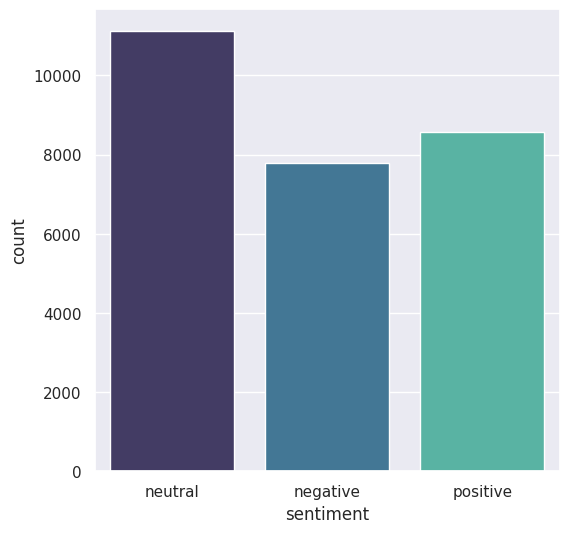

In [7]:
plt.figure(figsize=(6,6))
# plt.title('AgeGroup devided by Gender')
sn.countplot(data=dataset, x='sentiment', palette='mako')


## **Pre-Processing**

In [8]:
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words("english")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [9]:
def process(text,
            remove_punctuaction=True,
            remove_stopwords=False):
  text = text.lower()
  text = emoji.demojize(text)
  text = re.sub(r'(?:\@|https?\://)\S+', '', text, flags=re.MULTILINE)
  text = re.sub(r"what's", "what is ", text)
  text = re.sub(r"'s", " ", text)
  text = re.sub(r"'ve", " have ", text)
  text = re.sub(r"can't", "can not ", text)
  text = re.sub(r"n't", " not ", text)
  text = re.sub(r"i'm", "i am ", text)
  text = re.sub(r"'re", " are ", text)
  text = re.sub(r"'d", " would ", text)
  text = re.sub(r"'ll", " will ", text)
  if remove_punctuaction:
    text = text.translate(str.maketrans(' ', ' ', string.punctuation))
  if remove_stopwords:
    text = ' '.join([word for word in text.split() if word not in stopwords])
  text = re.sub(' +', ' ', text)
  return text

In [10]:
def label_encoding(labels):
  le = preprocessing.LabelEncoder()
  return le.fit_transform(labels), list(le.classes_)

In [11]:
dataset['text'] = dataset['text'].swifter.apply(lambda x: process(x))
dataset['sentiment'], classes = label_encoding(dataset['sentiment'])
classes

Pandas Apply:   0%|          | 0/27480 [00:00<?, ?it/s]

['negative', 'neutral', 'positive']

In [13]:
x_train_text, x_test_text, y_train, y_test = train_test_split(dataset['text'].to_numpy(),
                                                              dataset['sentiment'].to_numpy(),
                                                              test_size=0.2,
                                                              stratify=dataset['sentiment'].to_numpy())
LB = preprocessing.LabelBinarizer()
y_train = LB.fit_transform(y_train)
y_test = LB.transform(y_test)

## **Visualization**

In [14]:
def visulizer(representation, model_name):
  pca = PCA(n_components=2)
  representation_reduced = pca.fit_transform(representation)
  plt.figure(figsize=(8,8))
  title= 'Text representation generated by {}'.format(model_name)
  plt.title(title)
  sn.scatterplot(x=representation_reduced[:,0], y=representation_reduced[:,-1], hue=y_train.argmax(axis=1), palette='bright', legend=False)
  plt.show()
  return

def plot_confusion_matrix(confusion_matrix, title='', cmap ='RdPu'):
    df = pd.DataFrame(confusion_matrix, range(len(confusion_matrix)), range(len(confusion_matrix)))
    plt.figure(figsize=(6,4))
    if title == '' :
        plt.title('Confusion Matrix')
    else:
        plt.title('Confusion Matrix' + ' ' + title)
    sn.set(font_scale=1) # for label size
    sn.heatmap(df, annot=True, annot_kws={"size": 12},fmt='.0f',cmap=cmap) # font size
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()

def plot_learning_curve(history):
  history_dict = history.history
  acc = history_dict['accuracy']
  val_acc = history_dict['val_accuracy']
  loss = history_dict['loss']
  val_loss = history_dict['val_loss']
  epochs = range(1, len(acc) + 1)
  plt.plot(epochs, acc, 'r', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()
  return

## **Text Representation**

### **Text2Sequence**

In [16]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train_text)
X_train = tokenizer.texts_to_sequences(x_train_text)
X_train = pad_sequences(X_train, padding='post', maxlen=300)
X_test = tokenizer.texts_to_sequences(x_test_text)
X_test = pad_sequences(X_test, padding='post', maxlen=300)

### **Glove**

In [17]:
!gdown https://huggingface.co/stanfordnlp/glove/resolve/main/glove.42B.300d.zip
!unzip /content/glove.42B.300d.zip

Downloading...
From: https://huggingface.co/stanfordnlp/glove/resolve/main/glove.42B.300d.zip
To: /content/glove.42B.300d.zip
100% 1.88G/1.88G [07:21<00:00, 4.25MB/s]
Archive:  /content/glove.42B.300d.zip
  inflating: glove.42B.300d.txt      


In [18]:
embedding_vector_glove = {}
glove_file = open('/content/glove.42B.300d.txt', encoding="utf8")
for line in glove_file:
  value = line.split(' ')
  word = value[0]
  embedding_vector_glove[word] = np.array(value[1:], dtype='float32')
glove_file.close()

In [19]:
embedding_matrix_glove = np.zeros((x_train_text.shape[0],300))
for i, sentence in enumerate(x_train_text):
  embedding_vector = np.zeros((1, 300))
  tokens = sentence.split(' ')
  length = len(tokens)
  for token in tokens:
    try:
      embedding_vector += embedding_vector_glove.get(token)
    except:
      length -= 1
  if length>=1:
    embedding_matrix_glove[i] = embedding_vector/length
  else:
    embedding_matrix_glove[i] = embedding_vector

In [20]:
del embedding_vector_glove

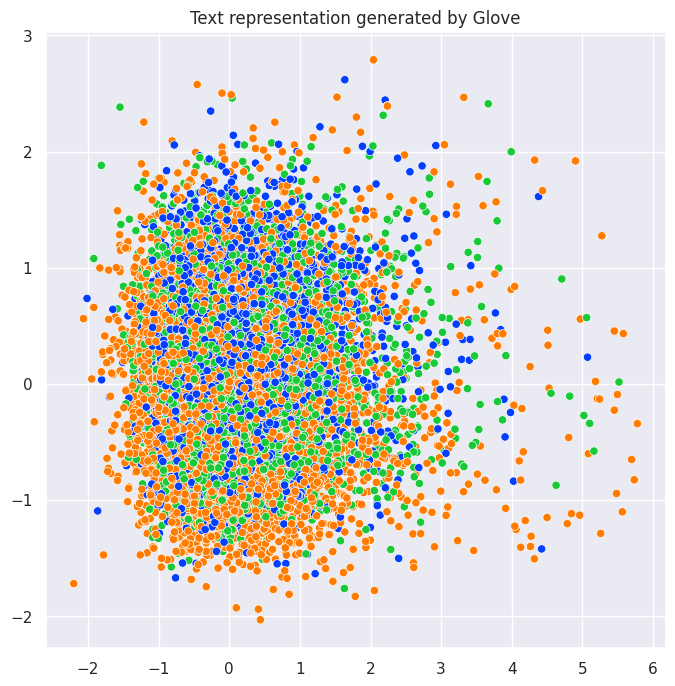

In [21]:
visulizer(embedding_matrix_glove, model_name='Glove')

### **Word2vec**

In [22]:
!pip install -q --upgrade --no-cache-dir gdown
!gdown 0B7XkCwpI5KDYNlNUTTlSS21pQmM

Access denied with the following error:

 	Too many users have viewed or downloaded this file recently. Please
	try accessing the file again later. If the file you are trying to
	access is particularly large or is shared with many people, it may
	take up to 24 hours to be able to view or download the file. If you
	still can't access a file after 24 hours, contact your domain
	administrator. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=0B7XkCwpI5KDYNlNUTTlSS21pQmM 



In [ ]:
word2vec_model = gensim.models.KeyedVectors.load_word2vec_format('/content/GoogleNews-vectors-negative300.bin.gz', binary=True)

In [ ]:
embedding_matrix_w2v = np.zeros((x_train_text.shape[0],300))
for i, sentence in enumerate(x_train_text):
  embedding_vector = np.zeros((1, 300))
  tokens = sentence.split(' ')
  length = len(tokens)
  for token in tokens:
    try:
      embedding_vector += word2vec_model[token]
    except:
      length -= 1
  if length>=1:
    embedding_matrix_w2v[i] = embedding_vector/length
  else:
    embedding_matrix_w2v[i] = embedding_vector

In [ ]:
del word2vec_model

In [ ]:
visulizer(embedding_matrix_w2v, model_name='Word2vec')

### **Bert Pretrained Embedding**

In [22]:
if torch.cuda.is_available():
  bert_model = SentenceTransformer('bert-base-uncased',device='cuda')
else:
  bert_model = SentenceTransformer('bert-base-uncased', device='cpu')

In [23]:
embedding_matrix_bert = bert_model.encode(x_train_text)

In [24]:
del bert_model

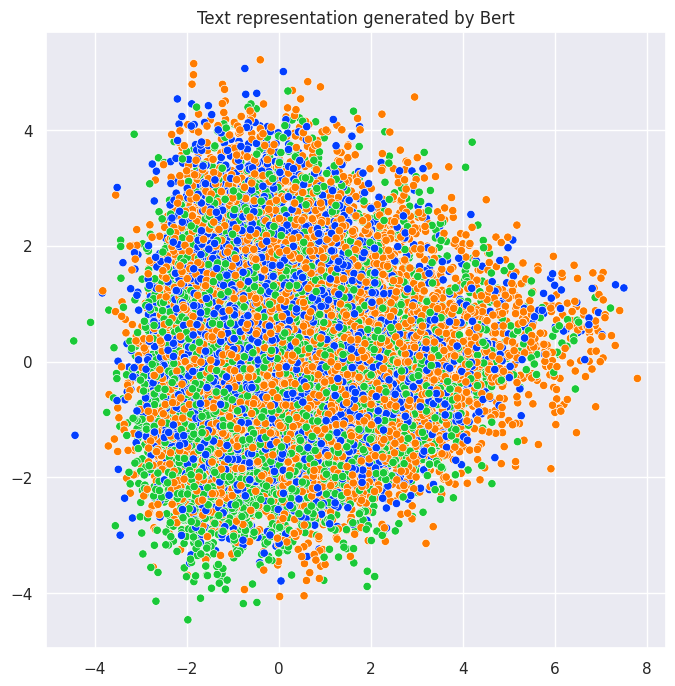

In [25]:
visulizer(embedding_matrix_bert, model_name='Bert')

## **Baseline Model**

### **Model Architecture**

In [26]:
def build_model(input_length,
                input_shape,
                embedding_matrix,
                output_dim=3,
                filters=256,
                kernel_size=3,
                drop_rate=0.2,
                units=64):

    model = keras.models.Sequential()

    #create embedding layer
    model.add(keras.layers.Embedding(embedding_matrix.shape[0],
                        output_dim=embedding_matrix.shape[-1],
                        input_length=input_length,
                        trainable = False,
                        embeddings_initializer = keras.initializers.Constant(embedding_matrix))
    )
    # 1st dropout
    model.add(keras.layers.Dropout(drop_rate))

    # 1st convolutional 1-D layer
    model.add(keras.layers.Conv1D(filters, kernel_size, padding = 'same', activation = 'relu'))

    #max pooling layer
    model.add(keras.layers.MaxPooling1D())

    model.add(keras.layers.Conv1D(filters, kernel_size, padding = 'same', activation = 'relu'))

    #max pooling layer
    model.add(keras.layers.MaxPooling1D())

    # 2nd convolutional 1-D layer
    model.add(keras.layers.Conv1D(filters, kernel_size, padding = 'same', activation = 'relu'))

    # global max pooling layer
    model.add(keras.layers.GlobalAveragePooling1D())

    # 1st dense layer
    model.add(keras.layers.Dense(units, activation = 'relu'))

    # 2nd dropout
    model.add(keras.layers.Dropout(drop_rate))

    # final dense layer
    model.add(keras.layers.Dense(output_dim, activation = 'softmax'))
    model.build(input_shape)
    return model

def train_model(model, X_train, y_train, batch_size=128, epochs=50, learning_rate=0.01):

  model.compile(loss = 'categorical_crossentropy',
                        optimizer = tensorflow.optimizers.SGD(learning_rate = learning_rate),
                        metrics=['accuracy'])
  print(model.summary())

  history = model.fit(
      X_train,
      y_train,
      batch_size = batch_size,
      epochs = epochs,
      shuffle = True)
  return history

def Evaluate_model(model, X_test, y_test, batch_size=128, title=''):
  prediction_prob = model.predict(X_test, verbose=1, batch_size=batch_size)
  predictions = prediction_prob.argmax(axis=1)
  plot_confusion_matrix(confusion_matrix(y_test, predictions), title=title, cmap ='Greens')
  report = classification_report(y_test, predictions, target_names=classes)
  print(classification_report(y_test, predictions, target_names=classes))
  macro_precision =  report['macro avg']['precision']
  macro_recall = report['macro avg']['recall']
  macro_f1 = report['macro avg']['f1-score']
  return macro_precision, macro_recall, macro_f1

### **Model Training & Evaluation**

In [27]:
model = build_model(input_length=X_train.shape[1], embedding_matrix=embedding_matrix_glove, input_shape=(None,300))
# print(model.summary())
history = train_model(model, X_train, y_train, batch_size=32, learning_rate=0.1)
macro_precision_glove, macro_recall_glove, macro_f1_glove = Evaluate_model(model, X_test, y_test, title='Results for Glove')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 300)          6595200   
                                                                 
 dropout (Dropout)           (None, 300, 300)          0         
                                                                 
 conv1d (Conv1D)             (None, 300, 256)          230656    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 150, 256)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 150, 256)          196864    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 75, 256)          0         
 1D)                                                    

KeyboardInterrupt: ignored

In [ ]:
model = build_model(input_length=X_train.shape[1], embedding_matrix=embedding_matrix_w2v, input_shape=(None,300))
history = train_model(model, X_train, y_train)
macro_precision_w2v, macro_recall_w2v, macro_f1_w2v = Evaluate_model(model, X_test, y_test, batch_size=128, title='Results for Word2vec')

In [30]:
model = build_model(input_length=X_train.shape[1], embedding_matrix=embedding_matrix_bert, input_shape=(None,300))
history = train_model(model, X_train, y_train)
macro_precision_bert, macro_recall_bert, macro_f1_bert = Evaluate_model(model, X_test, y_test, batch_size=128, title='Results for Bert')

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 300, 768)          16883712  
                                                                 
 dropout_4 (Dropout)         (None, 300, 768)          0         
                                                                 
 conv1d_6 (Conv1D)           (None, 300, 256)          590080    
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 150, 256)         0         
 1D)                                                             
                                                                 
 conv1d_7 (Conv1D)           (None, 150, 256)          196864    
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 75, 256)          0         
 1D)                                                  

KeyboardInterrupt: ignored

### **Comparison Study**

In [ ]:
conclusion = pd.DataFrame([
    ['Glove', macro_precision_glove, macro_recall_glove, macro_f1_glove],
    ['Word2vec', macro_precision_w2v, macro_recall_w2v, macro_f1_w2v],
    ['BERT', macro_precision_bert, macro_recall_bert, macro_f1_bert]
    ],
                          columns=["WordEmbedding","Macro Averaged Precision","Macro Averaged Recall","Macro Averaged F1-Score"])
conclusion = conclusion.set_index('Algorithm')
conclusion.style.background_gradient(cmap="YlOrRd")


### **Comparing with pre-trained model**

## **Inference**